In [2]:
import urllib
import pandas as pd
import re

# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

# 데이터 불러오기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

# 결측치 제거
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# 한글만 추출 (정규식 사용)
train_data['document'] = train_data['document'].apply(lambda x: re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\s]', ' ', str(x)))
test_data['document'] = test_data['document'].apply(lambda x: re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\s]', ' ', str(x)))

# 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

# 인덱스 리셋
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print(f'전처리 후 훈련 데이터 크기: {train_data.shape}')
print(f'전처리 후 테스트 데이터 크기: {test_data.shape}')

전처리 후 훈련 데이터 크기: (145140, 3)
전처리 후 테스트 데이터 크기: (48822, 3)


count    145140.000000
mean          8.023942
std           6.689301
min           0.000000
25%           4.000000
50%           6.000000
75%          10.000000
max          47.000000
Name: document, dtype: float64
max_token_len : 24


<Axes: >

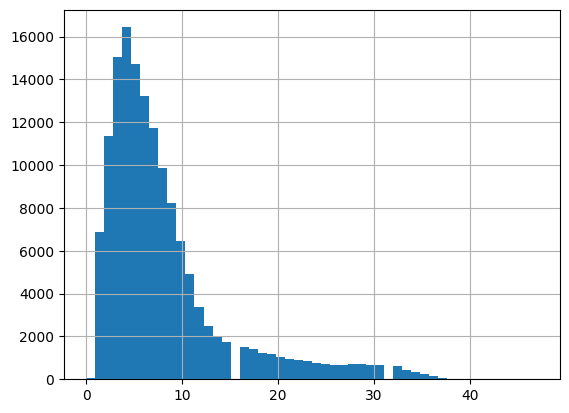

In [3]:
print(train_data['document'].map(lambda x: len(x.split())).describe())
import numpy as np
max_token_len = np.percentile(train_data['document'].map(lambda x: len(x.split())).to_numpy(), 95)
max_token_len = int(max_token_len)
print(f'max_token_len : {max_token_len}')
train_data['document'].apply(lambda x: len(x.split())).hist(bins=50)

In [4]:
import torch
import torch_directml
from transformers import PreTrainedTokenizerFast, GPT2ForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score
torch.set_default_dtype(torch.float16)
# 토크나이저 로드
tokenizer = PreTrainedTokenizerFast.from_pretrained('skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', pad_token='<pad>')

# KoGPT2 모델 로드 (이진 분류를 위한 GPT2ForSequenceClassification 사용)
model = GPT2ForSequenceClassification.from_pretrained('skt/kogpt2-base-v2', num_labels=2)  # num_labels=2로 설정
# DirectML 장치 설정
dml_device = torch_directml.device()  # DirectML 장치 설정
model.half().to(dml_device)  # 모델을 DirectML 장치로 이동

# 데이터 타입을 명확히 지정한 tokenize_and_encode 함수
def tokenize_and_encode(data, tokenizer):
    encodings = tokenizer(
        data['document'].tolist(),
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=128,
    )
    return encodings

# train_data와 test_data의 문자열 데이터를 정수형 텐서로 변환 (토크나이저 사용)
train_encodings = tokenize_and_encode(train_data, tokenizer)
test_encodings = tokenize_and_encode(test_data, tokenizer)

# 레이블은 이진 분류 작업이므로 int64로 변환 (CrossEntropyLoss를 사용할 경우)
train_labels = torch.tensor(train_data['label'].values, dtype=torch.int64)  # 정수형 레이블
test_labels = torch.tensor(test_data['label'].values, dtype=torch.int64)    # 정수형 레이블

# TensorDataset 및 DataLoader 생성 (배치 크기 줄임)
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Optimizer 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

# 손실 함수 설정 (CrossEntropyLoss 사용)
criterion = torch.nn.CrossEntropyLoss()

# 학습 루프 정의
for epoch in range(1):  # 에포크 수 설정
    model.train()
    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = [b.to(dml_device) for b in batch]  # 모든 텐서를 DirectML 장치로 이동
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        loss = criterion(logits, labels)  # CrossEntropyLoss 사용
        
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1} completed.')

# 모델 평가
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(dml_device) for b in batch]  # 모든 텐서를 DirectML 장치로 이동
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy:.4f}')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at skt/kogpt2-base-v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/sangho/miniconda3/envs/ml2/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/9072 [00:00<?, ?it/s]


RuntimeError: The GPU device does not support Double (Float64) operations!

<!-- 추론 -->

In [ ]:
# 데이터 셋을 토큰화, 토크나이져 로드, 모델로드
model_name = 'skt/kogpt2-base-v2'
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name,
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

# 대화형식/쳇봇
# 질문 답변형식으로 데이터를 인코딩

# question = '안녕하세요! 오늘 날씨가 어때요?'
# answer = '안녕하세요! 오늘 날씨는 맑고 화창합니다.'

# input_text = f'질문:{question} 답변:'
# target_text = f"{answer}"
# input_ids =  tokenizer.encode(input_text,add_special_tokens=True, truncation=True, max_length=128)
# target_ids =  tokenizer.encode(target_text,add_special_tokens=True, truncation=True, max_length=128)
# target_ids


# 모델 불러오기
# 데이터  로더 사용
import torch
import torch_directml
from torch.utils.data import Dataset, DataLoader
torch.set_default_dtype(torch.float16)
class QADataSet(Dataset):
  def __init__(self,tokenizer,question,answer,max_length = 128):
    self.tokenizer = tokenizer
    self.tokenizer.pad_token = tokenizer.eos_token
    self.question = question
    self.answer = answer
    self.max_length = max_length
    self.input_ids = []
    self.labels = []
    self.attention_mask = []
    for question, answer in zip(question,answer):
      input_text = f'질문:{question} 답변:'
      target_text = f"{answer}"
      input_encodings = tokenizer(input_text, padding='max_length', add_special_tokens=True, truncation=True, max_length=max_length)
      target_encodings = tokenizer(target_text,padding='max_length',add_special_tokens=True, truncation=True, max_length=max_length)

      self.input_ids.append(input_encodings['input_ids'])
      self.labels.append(target_encodings['input_ids'])
      self.attention_mask.append(input_encodings['attention_mask'])

  def __len__(self):
    return len(self.question)
  def __getitem__(self,idx):
    question = self.question[idx]
    answer = self.answer[idx]
    return {
      'input_ids': torch.tensor(self.input_ids[idx],dtype=torch.long),
      'attention_mask': torch.tensor(self.attention_mask[idx],dtype=torch.long),
      'labels' : torch.tensor(self.labels[idx],dtype=torch.long)
    }
questions = ['안녕하세요 오늘날씨가 어때요?','단위프로젝트 주제는 뭔가요?','프로젝트 목표는 뭔가요?']
answers = ['안녕하세요 오늘 날씨는 좋아요','내외부문서를 활용한 QA 시스템 입니다.',
           '환각을 방지하고 원하는 내외부 데이터 내에서 RAG 기반 LLM 활용 질의 응답 시스템 구현\
           ,문서를 벡터 형태로 임베딩하여 벡터데이터 ']


dataset = QADataSet(tokenizer, question=questions,answer=answers)
dataloader = DataLoader(dataset,batch_size=2)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch_directml.device()

# 모델 로드
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained(model_name)
# 옵티마이져
from transformers import AdamW
optimizer = AdamW(model.parameters(),lr=1e-5)
model.to(device)
# 스케줄러 적용
from transformers import get_linear_schedule_with_warmup
epochs = 10
total_steps = len(dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

model.train()

from tqdm import tqdm
iterator = tqdm(range(epochs))
for epoch in iterator:
  for batch in dataloader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids,attention_mask=attention_mask,labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    scheduler.step()
    iterator.set_description(f'Epoch {epoch+1} loss :{loss.item()}')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/home/sangho/miniconda3/envs/ml2/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: The GPU device does not support Double (Float64) operations!